In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=200)

In [214]:
class cell:
    normals = np.array([(0, 1, 0), (1, 0, 0), (0, -1, 0), (-1, 0, 0), (0, 0, -1), (0, 0, 1)])
    
    def __init__(self, position, dimensions):
        self.position = np.array(position)
        self.dimensions = np.array(dimensions)
        # N, E, S, W, V, H
        areas = [(np.abs(n) - 1)* dimensions for n in self.normals]
        self.areas = [(1 if i[0] == 0 else i[0]) * (1 if i[1] == 0 else i[1]) * (1 if i[2] == 0 else i[2]) for i in areas]
class equidistant2DMesh:
    def __init__(self, width, height, dimensions, start_x, start_y):
        self.delta_x, self.delta_y, self.delta_z = dimensions
        self.n_x = int(width / delta_x)
        self.n_y = int(height / delta_y)
        cells = []
        for x in np.linspace(start_x, width + start_x, self.n_x, endpoint=False):
            center_x = x + self.delta_x / 2
            current_cells = []
            for y in np.linspace(start_y, height + start_y, self.n_y, endpoint=False):
                center_y = y + self.delta_y / 2
                newcell = cell((center_x, center_y, 0), dimensions)
                current_cells += [newcell]
            cells += [current_cells]
        self.cells = np.array(cells)
        self.length = self.n_x * self.n_y
    def join(self, other):
        self.cells += other.cells
        self.length = len(self.cells)
    def getNorth(self, pos, n=1):
        return self.getSouth(pos, n=-n)
    def getSouth(self, pos, n=1):
        return pos - n
    def getWest(self, pos, n=1):
        return pos - self.n_y * n
    def getEast(self, pos, n=1):
        return self.getWest(pos, n=-n)
    def hasNorth(self, pos, n=1):
        return (pos + n) < (int(pos / self.n_y) + 1) * self.n_y
    def hasSouth(self, pos, n=1):
        return (pos - n) >= (int(pos / self.n_y)) * self.n_y
    def hasEast(self, pos, n=1):
        return pos < self.length - n * self.n_y
    def hasWest(self, pos, n=1):
        return pos >= self.n_y * n
    def index_to_i_j(self, index):
        n_x = int(index/self.n_y)
        n_y = index % self.n_y
        return [n_x, n_y]
    def i_j_to_index(self, i, j):
        return i * self.n_y + j
    def cell_type(self, pos):
        horizontalType = - int(not(self.hasWest(pos))) + int(not(self.hasEast(pos)))
        verticalType = - int(not(self.hasSouth(pos))) + int(not(self.hasNorth(pos)))
        return [horizontalType, verticalType]

In [215]:
u_mesh = equidistant2DMesh(width + 2* delta_x, height + delta_y, (delta_x, delta_y, 0), -delta_x, -delta_y/2)
u_mesh.cells[2][0].position

array([0.375, 0.   , 0.   ])

In [645]:
def eval_konti(pmesh, umesh, vmesh, u, v, delta_t):
    konti_residua = np.ones(pmesh.cells.shape)
    n_x = p_mesh.n_x
    n_y = p_mesh.n_y
    u_w = u[0:n_x, 0:n_y]
    u_e = u[1:n_x+1, 0:n_y]
    v_s = v[0:n_x, 0:n_y]
    v_n = v[0:n_x, 1:n_y + 1]
    return  -pmesh.delta_y * (u_e - u_w) - pmesh.delta_x * (v_n - v_s)
def update_u_v(pmesh, umesh, vmesh, u, v, p, delta_t, nu, u_rb, v_rb):
    u_star = np.copy(u)
    v_star = np.copy(v)
    druck_links = p[0:u_mesh.n_x - 2, 1:u_mesh.n_y - 1]
    druck_rechts = p[1:u_mesh.n_x - 1, 1:u_mesh.n_y - 1]
    n_x = p_mesh.n_x
    n_y = p_mesh.n_y
    dx = p_mesh.delta_x
    dy = p_mesh.delta_y
    dt = delta_t
   # print(p)
    pressure_grad_x = (p[1:n_x, 1:n_y - 1] - p[0:n_x - 1, 1:n_y - 1]) / dx
    u_e = u[2:n_x + 1, 1:n_y - 1]
    u_p = u[1:n_x    , 1:n_y - 1]
    u_w = u[0:n_x - 1, 1:n_y - 1]
    u_n = u[1:n_x    , 2:n_y]
    u_s = u[1:n_x    , 0:n_y - 2]
    v_se = v[1:n_x   , 1:n_y - 1]
    v_ne = v[1:n_x   , 2:n_y]
    v_nw = v[0:n_x -1, 2:n_y]
    v_sw = v[0:n_x -1, 1:n_y - 1]
    u_AW = (u_p + u_w) / 2
    u_AE = (u_e + u_p) / 2
    u_AS = (u_s + u_p) / 2
    u_AN = (u_n + u_p) / 2
   # print(u_AW, u_AE)
    v_AS = (v_se + v_sw) / 2
    v_AN = (v_ne + v_nw) / 2
    u_grad_w = (u_p - u_w) / dx
    u_grad_e = (u_e - u_p) / dx
    u_grad_s = (u_p - u_s) / dy
    u_grad_n = (u_n - u_p) / dy
    pressure_term = - pressure_grad_x * dx * dy
    #print("pressure term", pressure_term / dx / dy * dt)
    convection = -((- u_AW * u_AW + u_AE* u_AE) * umesh.delta_y +  (- v_AS*u_AS + v_AN * u_AN) * umesh.delta_x)
    #print("convection", convection)
    viscous = nu * ((-u_grad_w + u_grad_e) * umesh.delta_y + (-u_grad_s + u_grad_n) * umesh.delta_x)
    
    u_star[1:n_x, 1:n_y - 1] = u_p + delta_t / umesh.delta_x / umesh.delta_y * (pressure_term + convection + viscous)
    pressure_grad_y = (p[1:n_x - 1, 1:n_y] -p[1:n_x - 1, 0:n_y - 1]) / dx
    v_p = v[1:n_x - 1, 1:n_y]
    v_n = v[1:n_x - 1, 2:n_y + 1]
    v_s = v[1:n_x - 1, 0:n_y - 1]
    v_e = v[2:n_x    , 1:n_y]
    v_w = v[0:n_x - 2, 1:n_y]
    u_sw = u[1:n_x - 1, 0:n_y - 1]
    u_nw = u[1:n_x - 1, 1:n_y]
    u_ne = u[2:n_x    , 1:n_y]
    u_se = u[2:n_x    , 0:n_y - 1]
    v_AW = (v_p + v_w) / 2
    v_AE = (v_e + v_p) / 2
    v_AS = (v_s + v_p) / 2
    v_AN = (v_n + v_p) / 2
    u_AW = (u_nw + u_sw) / 2
    u_AE = (u_ne + u_se) / 2
    v_grad_w = (v_p - v_w) / vmesh.delta_x
    v_grad_e = (v_e - v_p) / vmesh.delta_x
    v_grad_s = (v_p - v_s) / vmesh.delta_y
    v_grad_n = (v_n - v_p) / vmesh.delta_y
    pressure_term = - pressure_grad_y * vmesh.delta_x * vmesh.delta_y
    convection = -((- v_AS*v_AS + v_AN*v_AN) * vmesh.delta_x +  (- v_AW*u_AW + v_AE * u_AE) * vmesh.delta_y)
    viscous = nu * ((-v_grad_w + v_grad_e) * vmesh.delta_y + (-v_grad_s + v_grad_n) * vmesh.delta_x)
    v_star[1:n_x - 1, 1:n_y] = v_p + delta_t / vmesh.delta_x / vmesh.delta_y * (pressure_term + convection + viscous)
    #print("u star vor RB", u_star)
    u_star[0, :] = 2 * u_rb[3] - u_star[1, :]
    u_star[u_mesh.n_x - 1, :] = 2 * u_rb[1] - u_star[u_mesh.n_x - 2, :]
    u_star[:, 0] = u_rb[2]
    u_star[:, u_mesh.n_y - 1] = u_rb[0]
    v_star[:, 0] = 2 * v_rb[2] - v_star[:, 1]
    v_star[:, v_mesh.n_y - 1] = 2 * v_rb[0] - v_star[:, v_mesh.n_y - 2]
    v_star[0, :] = v_rb[3]
    v_star[v_mesh.n_x - 1, :] = v_rb[1] 
    return u_star, v_star
def druckkorrekturmatrix(pmesh):
    m = np.zeros((pmesh.n_x * pmesh.n_y, pmesh.n_x * pmesh.n_y))
    for i in range(len(m)):
        dydx = pmesh.delta_y / pmesh.delta_x
        dxdy = 1 / dydx
        if pmesh.hasEast(i):
            m[i, pmesh.getEast(i)] = - dydx
            m[i, i] += dydx
        if pmesh.hasWest(i):
            m[i, pmesh.getWest(i)] = - dydx
            m[i, i] += dydx
        if pmesh.hasSouth(i):
            m[i, pmesh.getSouth(i)] = - dxdy
            m[i, i] += dxdy
        if pmesh.hasNorth(i):
            m[i, pmesh.getNorth(i)] = - dxdy
            m[i, i] += dxdy
    return m
def vkorrektur(pmesh, umesh, vmesh, pc, delta_t):
    u_c = np.zeros(umesh.cells.shape)
    #print(u_c.shape)
    v_c = np.zeros(vmesh.cells.shape)
    for i in range(1, umesh.n_x - 1):
        for j in range(1, umesh.n_y - 1):
            druck_links = pc[i - 1, j]
            druck_rechts = pc[i, j]
            u_c[i, j] = delta_t / umesh.delta_x * (druck_links - druck_rechts)
    for i in range(1, vmesh.n_x - 1):
        for j in range(1, vmesh.n_y - 1):
            druck_oben = pc[i, j]
            druck_unten = pc[i, j - 1]
            v_c[i, j] = delta_t / vmesh.delta_y * (druck_unten - druck_oben)
    return u_c, v_c

In [646]:
width, height = 1, 1
delta_x, delta_y = 0.025, 0.025
delta_t = 0.175
nu = 0.005
endtime = 5
timesteps = int(endtime / delta_t) +1
u_mesh = equidistant2DMesh(width + 2* delta_x, height + delta_y, (delta_x, delta_y, 0), -delta_x, -delta_y/2)
v_mesh = equidistant2DMesh(width + delta_x, height + 2 * delta_y, (delta_x, delta_y, 0), -delta_x/2, -delta_y)
p_mesh = equidistant2DMesh(width + delta_x, height + delta_y, (delta_x, delta_y, 0), -delta_x/2, -delta_x/2)
p = np.zeros((timesteps, p_mesh.n_x, p_mesh.n_y))
p[0] = 0
u = np.zeros((timesteps, u_mesh.n_x, u_mesh.n_y))
u[0, 0:u_mesh.n_x, u_mesh.n_y - 1] = 1
v = np.zeros((timesteps, v_mesh.n_x, v_mesh.n_y))
tol = 0.0001
alpha = 0.7
A = druckkorrekturmatrix(p_mesh) * delta_t
#druckrb = p_mesh.i_j_to_index(1, 1)
druckrb = (int(p_mesh.n_x / 2), int(p_mesh.n_y /2))
posdruck = druckrb[0] * p_mesh.n_y + druckrb[1]
A[posdruck] = 0
A[posdruck, posdruck] = 1
p[0, druckrb[0], druckrb[1]] = 0
timestep = 1
u_rb = [1, 0, 0, 0]
v_rb = [0, 0, 0, 0]
while (timestep < timesteps):
    print("Zeitschritt {}, Zeit: {}".format( timestep, timestep * delta_t))
    maxit = 100
    it = 1
    u_anfang = u[timestep - 1]
    v_anfang = v[timestep - 1]
    p_anfang = p[timestep - 1]
    res = 10000
    while it < maxit:
        #print("ITERATION", it)
        #print("u vorher", u_anfang, v_anfang, p_anfang)
        u_star, v_star = update_u_v(p_mesh, u_mesh, v_mesh, u_anfang, v_anfang, p_anfang, delta_t, nu, u_rb, v_rb)
        #print("u nachher", u_star, v_star)
        b = eval_konti(p_mesh, u_mesh, v_mesh, u_star, v_star, delta_t)
        b[druckrb] = 0
        #print("b", b)
        p_c = np.reshape(np.linalg.solve(A, np.reshape(b, (p_mesh.n_x * p_mesh.n_y), order='F')),  (p_mesh.n_x, p_mesh.n_y), order='F')
        #print("pc", p_c * alpha)
        #plt.imshow(p_c)
        #plt.show()
        p_anfang += p_c * alpha
        #print("Pneu", p_anfang, "\nPc", p_c * alpha)
        # u_c, v_c = vkorrektur(p_mesh, u_mesh, v_mesh, p_c, delta_t)
        #u_anfang, v_anfang = u_star + alpha * u_c, v_star + alpha*  v_c
        #u_anfang, v_anfang = u_star, v_star
        #print("uneu", u_star, "\nvneu", v_star)
        res = eval_konti(p_mesh, u_mesh, v_mesh, u_star, v_star, delta_t)
        #print("Residuum ", np.linalg.norm(res))
        if (np.linalg.norm(res) < tol):
            print("Fertig nach", it, "Iterationen")
            u[timestep] = u_star
            v[timestep] = v_star
            p[timestep] = p_anfang
            break
        it += 1
    timestep+=1
            

Zeitschritt 1, Zeit: 0.175
Fertig nach 35 Iterationen
Zeitschritt 2, Zeit: 0.35
Fertig nach 41 Iterationen
Zeitschritt 3, Zeit: 0.5249999999999999
Fertig nach 57 Iterationen
Zeitschritt 4, Zeit: 0.7
Fertig nach 77 Iterationen
Zeitschritt 5, Zeit: 0.875
Zeitschritt 6, Zeit: 1.0499999999999998
Fertig nach 1 Iterationen
Zeitschritt 7, Zeit: 1.2249999999999999
Fertig nach 35 Iterationen
Zeitschritt 8, Zeit: 1.4
Fertig nach 41 Iterationen
Zeitschritt 9, Zeit: 1.575
Fertig nach 57 Iterationen
Zeitschritt 10, Zeit: 1.75
Fertig nach 77 Iterationen
Zeitschritt 11, Zeit: 1.9249999999999998
Zeitschritt 12, Zeit: 2.0999999999999996
Fertig nach 1 Iterationen
Zeitschritt 13, Zeit: 2.275
Fertig nach 35 Iterationen
Zeitschritt 14, Zeit: 2.4499999999999997
Fertig nach 41 Iterationen
Zeitschritt 15, Zeit: 2.625
Fertig nach 57 Iterationen
Zeitschritt 16, Zeit: 2.8
Fertig nach 77 Iterationen
Zeitschritt 17, Zeit: 2.9749999999999996
Zeitschritt 18, Zeit: 3.15
Fertig nach 1 Iterationen
Zeitschritt 19, Zeit:

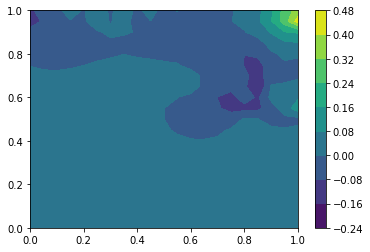

In [602]:
plt.contourf(np.linspace(0, 1, p_mesh.n_x), np.linspace(0, 1, p_mesh.n_y), np.transpose(p[15]))
plt.colorbar()

In [647]:
u_final = (u[:, 0:p_mesh.n_x, 0:p_mesh.n_y] + u[:, 1:p_mesh.n_x+1, 0:p_mesh.n_y])/2
v_final = (v[:, 0:p_mesh.n_x, 0:p_mesh.n_y] +  v[:, 0:p_mesh.n_x, 1:p_mesh.n_y + 1])/2
coords = np.array([a.position for a in np.reshape(p_mesh.cells, (p_mesh.n_x* p_mesh.n_y), 'F')])


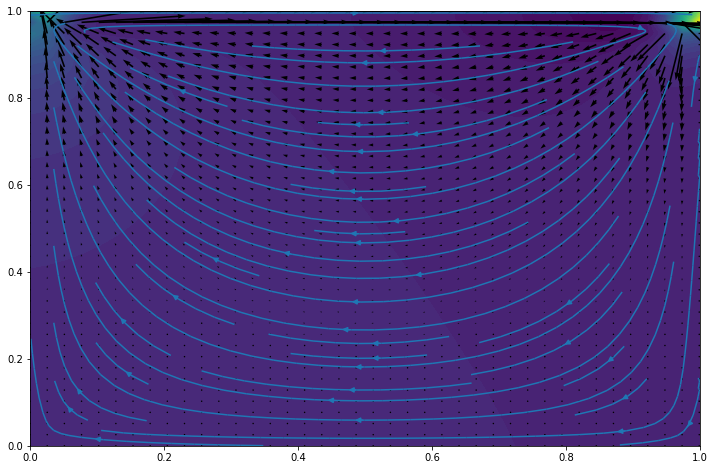

In [652]:
plt.figure(figsize=(12, 8))
n=1
u_current = np.reshape(u_final[n], (p_mesh.n_x* p_mesh.n_y), 'F')
v_current = np.reshape(v_final[n], (p_mesh.n_x* p_mesh.n_y), 'F')
plt.contourf(np.linspace(0, 1, p_mesh.n_x), np.linspace(0, 1, p_mesh.n_y), np.transpose(p[n]), 50)
plt.quiver(coords[:, 0], coords[:,1], u_current, v_current)
plt.streamplot(np.linspace(0, 1, p_mesh.n_y), np.linspace(0, 1, p_mesh.n_x), np.transpose(u_final[n]), np.transpose(v_final[n]))
plt.show()

In [619]:
coords

[array([0., 0., 0.]),
 array([0.05, 0.  , 0.  ]),
 array([0.1, 0. , 0. ]),
 array([0.15, 0.  , 0.  ]),
 array([0.2, 0. , 0. ]),
 array([0.25, 0.  , 0.  ]),
 array([0.3, 0. , 0. ]),
 array([0.35, 0.  , 0.  ]),
 array([0.4, 0. , 0. ]),
 array([0.45, 0.  , 0.  ]),
 array([0.5, 0. , 0. ]),
 array([0.55, 0.  , 0.  ]),
 array([0.6, 0. , 0. ]),
 array([0.65, 0.  , 0.  ]),
 array([0.7, 0. , 0. ]),
 array([0.75, 0.  , 0.  ]),
 array([0.8, 0. , 0. ]),
 array([0.85, 0.  , 0.  ]),
 array([0.9, 0. , 0. ]),
 array([0.95, 0.  , 0.  ]),
 array([1., 0., 0.]),
 array([0.  , 0.05, 0.  ]),
 array([0.05, 0.05, 0.  ]),
 array([0.1 , 0.05, 0.  ]),
 array([0.15, 0.05, 0.  ]),
 array([0.2 , 0.05, 0.  ]),
 array([0.25, 0.05, 0.  ]),
 array([0.3 , 0.05, 0.  ]),
 array([0.35, 0.05, 0.  ]),
 array([0.4 , 0.05, 0.  ]),
 array([0.45, 0.05, 0.  ]),
 array([0.5 , 0.05, 0.  ]),
 array([0.55, 0.05, 0.  ]),
 array([0.6 , 0.05, 0.  ]),
 array([0.65, 0.05, 0.  ]),
 array([0.7 , 0.05, 0.  ]),
 array([0.75, 0.05, 0.  ]),
 ar

In [447]:
u_mesh.cells.shape

(6, 5)

In [314]:
p = np.zeros((5, 5))
p[0, 3] = -0.007
p[4, 3] = -0.007

In [319]:
np.matmul(np.linalg.inv(A), np.reshape(p, (25), 'F')) 

array([-0.02245455, -0.02032727, -0.01843636, -0.02032727, -0.02245455, -0.02458182, -0.02009091, -0.01465455, -0.02009091, -0.02458182, -0.0312    , -0.0208    ,  0.        , -0.0208    ,
       -0.0312    , -0.04821818, -0.03190909, -0.02374545, -0.03190909, -0.04821818, -0.04154545, -0.03487273, -0.03116364, -0.03487273, -0.04154545])